# Bayesian Optimization and Neural Network Model Training on the Boston Housing Dataset

In this project, we will use the Boston Housing dataset, a popular dataset for regression problems. The Boston Housing dataset contains information about the housing values in suburbs of Boston. There are 506 samples and 13 feature variables in this dataset. Our objective is to predict the value of houses in the suburbs of Boston based on these features.

The task will be accomplished in two major steps. First, we will use a simple neural network (NN) model for prediction, which will help us understand the performance of a baseline model on this dataset. Then, we will use Bayesian optimization (BO) to search for the optimal hyperparameters of the NN model to improve its performance.

This tutorial demonstrates how to use machine learning tools in Python for model training and hyperparameter optimization. The libraries we'll use include TensorFlow, Keras, scikit-learn, and GPyOpt.


## 1. Preparing the Environment and Data

We start by importing the necessary libraries and loading the Boston Housing dataset. We then normalize the features for effective training of the neural network model. 

We also set up the path to save the results of our model training and hyperparameter optimization.


In [17]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.datasets import boston_housing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import GPyOpt
from tqdm import tqdm

from joblib import Parallel, delayed
from concurrent.futures import ProcessPoolExecutor, as_completed

import seaborn as sns
import time


# Set up folders for saving results
notebook_fname = "GpyOpt_hyperparameter_YW_master"
folder_name = "/Model_Saved/"

model_path = f'./{folder_name}/{notebook_fname}/'

if not os.path.exists(model_path):
    os.makedirs(model_path)
    print(f"Folder '{model_path}' created.")
else:
    print(f"Folder '{model_path}' already exists.")


Folder './/Model_Saved//GpyOpt_hyperparameter_YW_master/' already exists.


##### Load and normalize the Boston Housing dataset


In [18]:
# Load the Boston Housing dataset
(x_train, y_train), (x_test, y_test) = boston_housing.load_data()

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Standardize the input data
scaler       = StandardScaler().fit(x_train)
x_train_norm = scaler.transform(x_train)
x_test_norm  = scaler.transform(x_test)
 

(404, 13) (404,)
(102, 13) (102,)


## 2. Training the Baseline Neural Network Model

Next, we define and train a baseline neural network model on the training set. We will use the Mean Absolute Error (MAE) or Mean Squared Error (MSE) as the loss function. We can evaluate the model's performance based on either the validation loss or the R2 score. The training process is timed for performance measurement.

In [19]:
# Define the model architecture
def create_model(num_hidden, num_nodes, dropout_rate, loss_class):
    model = Sequential()
    model.add(Dense(num_nodes, input_dim=13, activation='relu'))
    if loss_class == 0: 
        loss_func = 'mse'
    elif loss_class == 1: 
        loss_func = 'mae'
    else:
        raise ValueError(f"Invalid loss function '{loss}'. Valid options are 'mse' or 'mae'.")
    
    for i in range(num_hidden):
        model.add(Dense(num_nodes, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='linear'))
    model.compile(loss=loss_func, optimizer='adam')
    return model

# Model training
start_time = time.time()

num_hidden   = 2
num_nodes    = 32
dropout_rate = 0.368187
loss_class   = 1

model = create_model(num_hidden, num_nodes, dropout_rate, loss_class)
history = model.fit(x_train_norm, y_train, validation_data = (x_test_norm, y_test),
                    epochs=50, batch_size=32, verbose=0)

elapsed_time = time.time() - start_time
print("Time taken: ", int(elapsed_time), "seconds")



# ----- we can evaluate the model by the validation loss
score_loss = model.evaluate(x_test_norm, y_test, verbose=0)
print(f'validation loss: {score_loss:.4f}')

# ----- or by the R2 score
y_test_pred = model.predict(x_test_norm, verbose=0)
score_r2    = r2_score(y_test, y_test_pred)
print(f'score_r2: {score_r2:.4f}')

Time taken:  3 seconds
validation loss: 3.0747
score_r2: 0.7629


#####  Plot training and validation loss

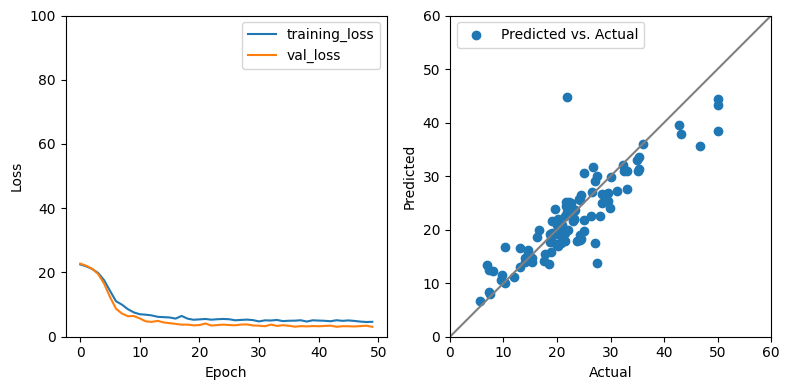

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Plot training and validation loss in the first subplot
ax1.plot(history.history['loss'], label='training_loss')
ax1.plot(history.history['val_loss'], label='val_loss')
ax1.set_ylim(0, 100)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot predicted vs actual in the second subplot
lims = [0, 60]
ax2.set_xlim(lims)
ax2.set_ylim(lims)
ax2.plot(lims, lims, color='grey')
ax2.scatter(y_test, y_test_pred, label='Predicted vs. Actual')
ax2.set_xlabel('Actual')
ax2.set_ylabel('Predicted')
ax2.legend()

plt.tight_layout()
plt.show()



# 3. Hyperparameter Optimization with Bayesian Optimization

We use Bayesian optimization to fine-tune the hyperparameters of our neural network. The objective function to be optimized is defined in the `BO_hyper_objective` function, which takes hyperparameters as input and returns the R-square score and validation loss.

In [21]:
start_time = time.time()

# Define the objective function
def BO_hyper_objective(params, score_loss_list):
    
    global bo_iteration # indicate that bo_iteration is a global variable

    num_hidden   = int(params[0][0])
    num_nodes    = int(params[0][1])
    dropout_rate = params[0][2]
    loss_class   = int(params[0][3])

    model = create_model(num_hidden, num_nodes, dropout_rate, loss_class)

    model.fit(x_train_norm, y_train, epochs=50, batch_size=32, verbose=0)

    score_loss = model.evaluate(x_test_norm, y_test, verbose=0)

    y_test_pred = model.predict(x_test_norm, verbose=0)
    score_r2    = r2_score(y_test, y_test_pred)

    # Append the score_loss to the scores list
    score_loss_list.append(score_loss)
    
    # show the progress 
    bo_iteration = bo_iteration+1
    print(f'Iteration: {bo_iteration}/{n_initial_points+n_iterations}')

    return score_r2, score_loss

# Define the search space for hyperparameters
search_space = [{'name': 'num_hidden',   'type': 'discrete',   'domain': (1, 2, 3, 4)},
                {'name': 'num_nodes',    'type': 'discrete',   'domain': (32, 64, 128, 256)},
                {'name': 'dropout_rate', 'type': 'continuous', 'domain': (0.1, 0.5)},
                {'name': 'loss_class',   'type': 'discrete',   'domain': (0, 1)}]




# Define the dataframe to store the sampled parameters and corresponding objective values
hypertable = pd.DataFrame(columns=['score_r2', 'score_loss', 'num_hidden', 'num_nodes', 'dropout_rate', 'loss_class'])

# Set up the optimizer
bo              = None
score_loss_list = []
bo_iteration    = 0

# ----- Method I: use random starting point -----
n_initial_points = 10
n_iterations     = 50
np.random.seed(1)

bo = GPyOpt.methods.BayesianOptimization(f=lambda x: BO_hyper_objective(x, score_loss_list)[0],  # Use only score_r2 as objective function
                                         domain=search_space,
                                         model_type='GP',
                                         initial_design_numdata=n_initial_points,
                                         init_design_type='random',
                                         acquisition_type='EI',
                                         acquisition_optimizer_type='lbfgs',
                                         acquisition_jitter=0.01,
                                         maximize=True)
# ----- Method II: use know good starting point ----- 
# n_iterations     = 40

# bo = GPyOpt.methods.BayesianOptimization(f=lambda x: BO_hyper_objective(x)[0],  # Use only score_r2 as objective function
#                                          domain=search_space,
#                                          model_type='GP',
#                                          initial_design_numdata=0,
#                                          acquisition_type='EI',
#                                          acquisition_optimizer_type='lbfgs',
#                                          acquisition_jitter=0,
#                                          maximize=True)

# # bo.X = np.array([[4, 256, 0.021745, 0]])
# # bo.Y = np.array([-0.839299]).reshape(-1,1)

# bo.X = np.array([[1.0, 128.0, 0.010000,1.0]])
# bo.Y = np.array([-0.771314]).reshape(-1,1)

# ---------------------------------------------------

bo.run_optimization(max_iter=n_iterations)

# Print the best hyperparameters and objective value found
best_hyperparameters = ", ".join("{:.4f}".format(h) for h in bo.x_opt)
print("Best hyperparameters: {}".format(best_hyperparameters))
print("Best objective value:", -bo.fx_opt)

elapsed_time = time.time() - start_time
print("Time taken: ", int(elapsed_time), "seconds")

Iteration: 1/60
Iteration: 2/60
Iteration: 3/60
Iteration: 4/60
Iteration: 5/60
Iteration: 6/60
Iteration: 7/60
Iteration: 8/60
Iteration: 9/60
Iteration: 10/60
Iteration: 11/60
Iteration: 12/60
Iteration: 13/60
Iteration: 14/60
Iteration: 15/60
Iteration: 16/60
Iteration: 17/60
Best hyperparameters: 4.0000, 256.0000, 0.1000, 1.0000
Best objective value: 0.8433105132328607
Time taken:  38 seconds


##### documenting the search model hyperparameters

In [22]:
# Add the sampled hyperparameters and objective values to the dataframe
for i in range(len(bo.X)):
    row = dict(zip(['num_hidden', 'num_nodes', 'dropout_rate', 'loss_class'], bo.X[i]))
    row['score_r2']   = -bo.Y.flatten()[i]
    row['score_loss'] = np.array(score_loss_list)[i]
    
    # print(row)
    hypertable.loc[len(hypertable)] = row

# tablulate all the search score_r2 and hyperparameters
display(hypertable)


,score_r2,score_loss,num_hidden,num_nodes,dropout_rate,loss_class
0,0.720592,23.258961,2.0,32.0,0.368187,0.0
1,0.683546,3.495369,4.0,64.0,0.266922,1.0
2,0.684850,26.234261,1.0,32.0,0.323476,0.0
3,0.762585,19.763353,1.0,256.0,0.156155,0.0
4,0.691154,3.569031,4.0,64.0,0.179241,1.0
5,0.708274,24.284380,2.0,32.0,0.420298,0.0
6,0.541934,38.131172,4.0,128.0,0.487305,0.0
7,0.750916,20.734692,2.0,64.0,0.225370,0.0
8,0.622309,4.308936,4.0,128.0,0.376929,1.0
9,0.715787,23.659012,1.0,32.0,0.450556,0.0


##### compare different ways of evaluating a model: loss function vs R2 score

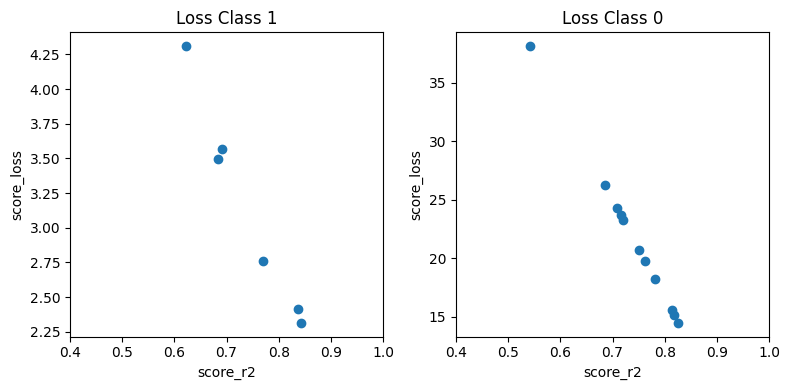

In [23]:
# ----- to see if the score_r2 is as good as score_loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Plot scatter plot for loss_class=1 in the first subplot
ax1.scatter(hypertable.loc[hypertable['loss_class'] == 1, 'score_r2'], 
            hypertable.loc[hypertable['loss_class'] == 1, 'score_loss'])
ax1.set(xlabel='score_r2', ylabel='score_loss', title='Loss Class 1', xlim=(0.4, 1))

# Plot scatter plot for loss_class=0 in the second subplot
ax2.scatter(hypertable.loc[hypertable['loss_class'] == 0, 'score_r2'], 
            hypertable.loc[hypertable['loss_class'] == 0, 'score_loss'])
ax2.set(xlabel='score_r2', ylabel='score_loss', title='Loss Class 0', xlim=(0.4, 1))

plt.tight_layout()
plt.show()



## 4. Plotting the Bayesian Optimization Results
We plot various graphs such as training and validation loss against epochs, predicted vs actual values and R-square score for each iteration. This provides visual insights into the model's performance.


,score_r2,score_loss,num_hidden,num_nodes,dropout_rate,loss_class
0,0.843311,2.314339,4.0,256.0,0.100000,1.0
1,0.837757,2.411570,4.0,256.0,0.100000,1.0
2,0.826129,14.473666,2.0,256.0,0.158486,0.0
3,0.818517,15.107327,2.0,256.0,0.100000,0.0
4,0.813118,15.556767,3.0,256.0,0.160095,0.0
5,0.781123,18.220152,2.0,256.0,0.500000,0.0
6,0.770845,2.757175,2.0,256.0,0.500000,1.0
7,0.762585,19.763353,1.0,256.0,0.156155,0.0
8,0.750916,20.734692,2.0,64.0,0.225370,0.0
9,0.720592,23.258961,2.0,32.0,0.368187,0.0


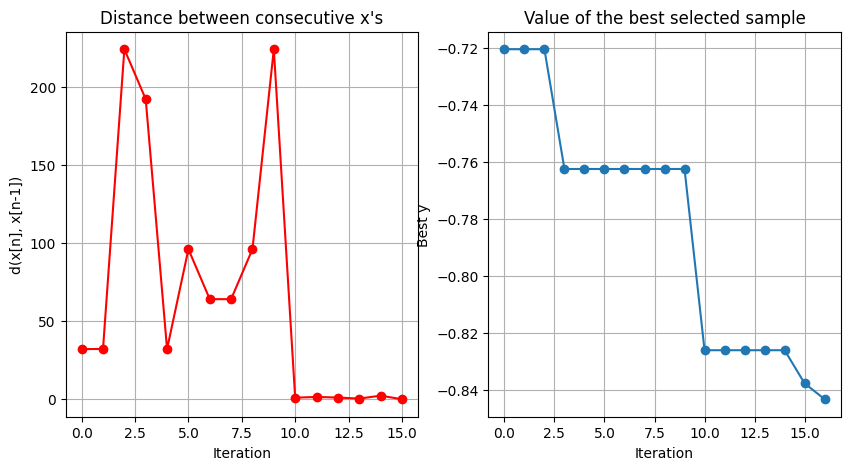

In [24]:
hypertable_sort = hypertable.sort_values(by = ['score_r2'], ascending=False, ignore_index = True) # sort the list start from the best results
display(hypertable_sort)

# plot the convergence
bo.plot_convergence()

##### plot the R2 score for each iteration (iteration = n_initial_points + n_iterations)

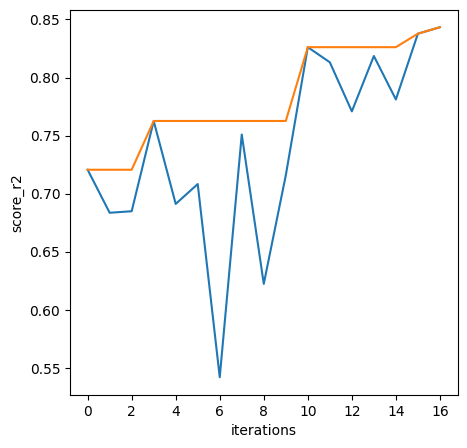

In [25]:
plt.figure(figsize=(5, 5))
plt.plot(hypertable.index, hypertable['score_r2'])
plt.plot(-bo.Y_best)
plt.xlabel('iterations')
plt.ylabel('score_r2')
plt.show()

## 5. make the BO search parallel

Parallelizing the Bayesian Optimization: To speed up the hyperparameter tuning process, we use joblib's Parallel function to run multiple instances of Bayesian optimization in parallel. Each of these instances performs a certain number of initial random samplings followed by a series of Bayesian optimization iterations. The best hyperparameters found by each instance are then returned and stored.

- generate `num_ensemble` BO search in parallel
- in each BO search: do random sampling of `n_initial_points` and then BO for `n_iterations`

In [26]:
def run_bayesian_optimization(n_initial_points, n_iterations, seed, hypertable, score_loss_list):
    
    BO_X_data, BO_Y_data, BO_Y_best_data = [], [], []

    bo = None # initializing the bo variable
    np.random.seed(seed)

    # Set up the optimizer
    bo = GPyOpt.methods.BayesianOptimization(f=lambda x: BO_hyper_objective(x,score_loss_list)[0],  # Use only score_r2 as objective function
                                             domain=search_space,
                                             model_type='GP',
                                             initial_design_numdata=n_initial_points,
                                             init_design_type='random',
                                             acquisition_type='EI',
                                             acquisition_optimizer_type='lbfgs',
                                             acquisition_jitter=0.05,
                                             maximize=True)

    bo.run_optimization(max_iter=n_iterations)

    # Print the best hyperparameters and objective value found
    best_hyperparameters = ", ".join("{:.4f}".format(h) for h in bo.x_opt)
    print("Best hyperparameters: {}".format(best_hyperparameters))
    print("Best objective value:", -bo.fx_opt)
    
    BO_X_data.append(bo.X)
    BO_Y_data.append(-bo.Y.flatten())
    BO_Y_best_data.append(-bo.Y_best.flatten())

    # Add the sampled hyperparameters and objective values to the dataframe
    for i in range(len(bo.X)):
        row = dict(zip(['num_hidden', 'num_nodes', 'dropout_rate', 'loss_class'], bo.X[i]))
        row['score_r2'] = -bo.Y.flatten()[i]
        row['score_loss'] = np.array(score_loss_list)[i]

        # print(row)
        hypertable.loc[len(hypertable)] = row
        
        # we will have the hypertable_sort with i = 0 having highest `score_r2` in each ensemble
        hypertable_sort = hypertable.sort_values(by = ['score_r2'], ascending=False, ignore_index = True) # sort the list start from the best results
    
    bo = None # initializing the bo variable
    
    return hypertable, hypertable_sort, BO_X_data, BO_Y_data, BO_Y_best_data
# -----------------------------------------------------------------------------------


# Parallelize the for loop using joblib
num_ensemble = 10

# Set the random seed
rng = np.random.RandomState(123)
seeds = rng.permutation(num_ensemble)

# ----- I: Parallel ------
# Define the dataframe to store the sampled parameters and corresponding objective values
hypertable = pd.DataFrame(columns=['score_r2', 'score_loss', 'num_hidden', 'num_nodes', 'dropout_rate', 'loss_class'])

# BO model parameters
n_initial_points = 10
n_iterations     = 30

empty_list = [list() for _ in range(num_ensemble)]

results = Parallel(n_jobs=-1)(delayed(run_bayesian_optimization)(n_initial_points, n_iterations, seeds[i], hypertable, empty_list[i]) for i in range(num_ensemble))
# ----- II: for loop -----
# results = []
# for seed in tqdm(seeds):
#     # print(seed)
#     # Define the dataframe to store the sampled parameters and corresponding objective values
#     hypertable = pd.DataFrame(columns=['score_r2', 'score_loss', 'num_hidden', 'num_nodes', 'dropout_rate', 'loss_class'])

#     # BO model parameters
#     n_initial_points = 10
#     n_iterations     = 30

#     result = run_bayesian_optimization(n_initial_points, n_iterations, seed, hypertable)
#     results.append(result)
# ---------------------------------


Iteration: 18/40
Iteration: 18/40
Iteration: 18/40
Iteration: 18/40
Iteration: 18/40
Iteration: 18/40
Iteration: 18/40
Iteration: 18/40
Iteration: 19/40
Iteration: 19/40
Iteration: 19/40
Iteration: 19/40
Iteration: 19/40
Iteration: 19/40
Iteration: 19/40
Iteration: 19/40
Iteration: 20/40
Iteration: 20/40
Iteration: 20/40
Iteration: 20/40
Iteration: 20/40
Iteration: 20/40
Iteration: 20/40
Iteration: 21/40
Iteration: 21/40
Iteration: 21/40
Iteration: 20/40
Iteration: 21/40
Iteration: 21/40
Iteration: 21/40
Iteration: 21/40
Iteration: 22/40
Iteration: 21/40
Iteration: 22/40
Iteration: 22/40
Iteration: 22/40
Iteration: 22/40
Iteration: 22/40
Iteration: 22/40
Iteration: 23/40
Iteration: 23/40
Iteration: 22/40
Iteration: 23/40
Iteration: 23/40
Iteration: 23/40
Iteration: 23/40
Iteration: 23/40
Iteration: 24/40
Iteration: 24/40
Iteration: 23/40
Iteration: 24/40
Iteration: 24/40
Iteration: 25/40
Iteration: 24/40
Iteration: 24/40
Iteration: 24/40
Iteration: 24/40
Iteration: 25/40
Iteration: 26/

In [27]:
# Combine the resulting dataframes from all iterations into one dataframe
hypertable_ensemble      = pd.concat([r[0] for r in results], ignore_index=False)
hypertable_sort_ensemble = pd.concat([r[1] for r in results], ignore_index=False)

print('-----------------------------------------------------------')
print('unsorted table for checking repeatable random inital points')
print('-----------------------------------------------------------')
display(hypertable_ensemble.loc[hypertable_ensemble.index == 0])
hypertable_sort.to_excel(model_path+'BO_hyperparameter.xlsx')

-----------------------------------------------------------
unsorted table for checking repeatable random inital points
-----------------------------------------------------------


,score_r2,score_loss,num_hidden,num_nodes,dropout_rate,loss_class
0,0.745019,21.225595,3.0,128.0,0.338934,0.0
0,0.739557,21.680290,1.0,64.0,0.134852,0.0
0,0.527306,39.348888,4.0,128.0,0.463837,0.0
0,0.804950,2.623190,4.0,256.0,0.209635,1.0
0,0.773825,3.150290,4.0,32.0,0.270437,1.0
0,0.796046,16.977938,3.0,128.0,0.336345,0.0
0,0.666818,27.735353,2.0,32.0,0.368187,0.0
0,0.643847,29.647539,3.0,64.0,0.496090,0.0
0,0.723193,3.325209,3.0,128.0,0.329104,1.0
0,0.730994,22.393112,1.0,128.0,0.414134,0.0


In [28]:
# Print the dataframe with sampled parameters and corresponding objective values
print('-----------------------------------------------------------')
print('sorted table to get the best hyperparameters in each ensemble')
print('-----------------------------------------------------------')
display(hypertable_sort_ensemble.loc[hypertable_sort_ensemble.index == 0])
hypertable_sort_ensemble.to_excel(model_path+'BO_hyperparamete_sort.xlsx')

-----------------------------------------------------------
sorted table to get the best hyperparameters in each ensemble
-----------------------------------------------------------


,score_r2,score_loss,num_hidden,num_nodes,dropout_rate,loss_class
0,0.785069,2.938757,2.0,32.0,0.100000,1.0
0,0.835484,13.694965,3.0,128.0,0.240906,0.0
0,0.818004,15.150086,4.0,128.0,0.109960,0.0
0,0.849478,12.529991,4.0,256.0,0.196764,0.0
0,0.854938,12.075490,4.0,256.0,0.100000,0.0
0,0.840378,13.287576,3.0,128.0,0.100000,0.0
0,0.818658,15.095619,2.0,256.0,0.100000,0.0
0,0.809873,15.826927,2.0,128.0,0.121790,0.0
0,0.823487,2.450376,3.0,256.0,0.100000,1.0
0,0.848394,12.620296,2.0,256.0,0.182414,0.0


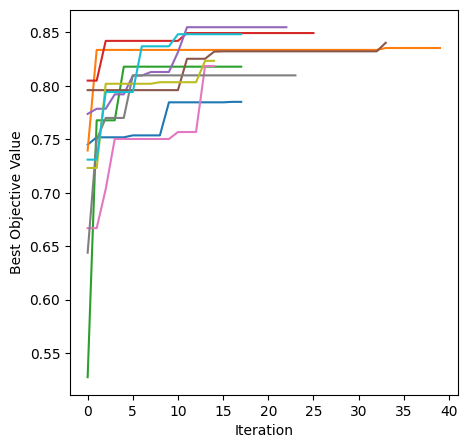

In [29]:
BO_Y_best_data_list = [r[4] for r in results]

plt.figure(figsize=(5, 5))
for i, BO_Y_best_data in enumerate(BO_Y_best_data_list):
    plt.plot(BO_Y_best_data[0], label=f'Ensemble {i+1}')
plt.xlabel('Iteration')
plt.ylabel('Best Objective Value')
# plt.legend()
plt.show()


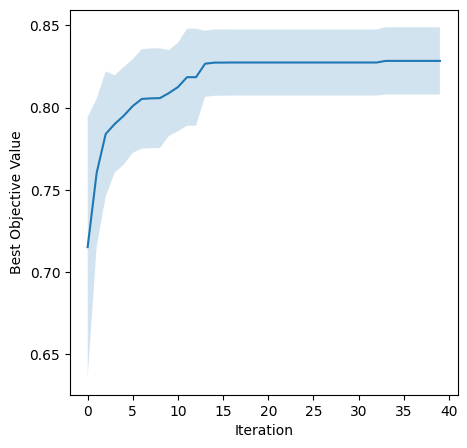

In [30]:
# Extract the BO_Y_best_data from results
BO_Y_best_data_list = [r[4] for r in results]

# Pad the BO_Y_best_data arrays with the maximum value if their length is less than 40
BO_Y_best_data_padded = []
for BO_Y_best_data in BO_Y_best_data_list:
    if len(BO_Y_best_data[0]) < 40:
        max_value = np.max(BO_Y_best_data[0])
        padding_length = 40 - len(BO_Y_best_data[0])
        padded_data = np.pad(BO_Y_best_data[0], (0, padding_length), mode='constant', constant_values=max_value)
        BO_Y_best_data_padded.append(padded_data)
    else:
        BO_Y_best_data_padded.append(BO_Y_best_data[0])

# Convert the list of padded arrays to a numpy array
BO_Y_best_data_padded = np.array(BO_Y_best_data_padded)

# Compute the mean and standard deviation of the padded arrays
mean = np.mean(BO_Y_best_data_padded, axis=0)
std  = np.std(BO_Y_best_data_padded, axis=0)

# Plot the mean and standard deviation as a function of iteration
plt.figure(figsize=(5, 5))
plt.plot(mean)
plt.fill_between(np.arange(mean.shape[0]), mean-std, mean+std, alpha=0.2)
plt.xlabel('Iteration')
plt.ylabel('Best Objective Value')
plt.savefig(model_path+'BO_Y_best_data_plot.png') # Save the plot as a file
plt.show() # Display the plot


dummy code for testing 

In [31]:
# import numpy as np
# import GPyOpt

# # Set the random seed for reproducibility
# np.random.seed(123)

# # Define the objective function to be optimized
# def objective_function(x):
#     y = np.sin(5*x[0]) * (1 - np.tanh(x[0]**2))
#     return y

# # Define the bounds of the search space
# bounds = [{'name': 'x', 'type': 'continuous', 'domain': (-5, 5)}]

# # Set the number of initial points and optimization iterations
# n_initial_points = 5
# n_iterations = 10

# # Create the GPyOpt object with the objective function and bounds
# optimizer = GPyOpt.methods.BayesianOptimization(f=objective_function, 
#                                                 domain=bounds, 
#                                                 initial_design_numdata=n_initial_points,
#                                                 init_design_type='random',
#                                                 acquisition_type='EI', # Set the acquisition function to use
#                                                 batch_size=4, # Number of points to evaluate in parallel
#                                                 num_cores=4, # Number of CPU cores to use for parallel evaluation
#                                                 acquisition_jitter=0.01
#                                                 ) 

# # Run the optimization for n_iterations iterations in parallel
# optimizer.run_optimization(max_iter=n_iterations)

# # Print the best found solution
# print("Best solution found: x = {0:.4f}, y = {1:.4f}".format(optimizer.x_opt[0], optimizer.fx_opt))
# optimizer.plot_convergence()
